## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'
import variational
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from itertools import cycle
import os
import time
import math
import pandas as pd
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
    
import copy
import torch.nn as nn
from torch.autograd import Variable
from typing import List
import itertools
from tqdm.autonotebook import tqdm
from models import *
import models
from logger import *

from thirdparty.repdistiller.helper.util import adjust_learning_rate as sgda_adjust_learning_rate
from thirdparty.repdistiller.distiller_zoo import DistillKL, HintLoss, Attention, Similarity, Correlation, VIDLoss, RKDLoss
from thirdparty.repdistiller.distiller_zoo import PKT, ABLoss, FactorTransfer, KDSVD, FSP, NSTLoss

from thirdparty.repdistiller.helper.loops import train_distill, train_distill_hide, train_distill_linear, train_vanilla, train_negrad, train_bcu, train_bcu_distill, validate
from thirdparty.repdistiller.helper.pretrain import init

/tmp/ipykernel_27082/2162111138.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Metrics1

In [2]:
from utils import *
def get_metrics(model,dataloader,criterion,samples_correctness=False,use_bn=False,delta_w=None,scrub_act=False):
    activations=[]
    predictions=[]
    if use_bn:
        model.train()
        dataloader = torch.utils.data.DataLoader(retain_loader.dataset, batch_size=128, shuffle=True)
        for i in range(10):
            for batch_idx, (data, target) in enumerate(dataloader):
                data, target = data.to(args.device), target.to(args.device)            
                output = model(data)
    dataloader = torch.utils.data.DataLoader(dataloader.dataset, batch_size=1, shuffle=False)
    model.eval()
    metrics = AverageMeter()
    mult = 0.5 if args.lossfn=='mse' else 1
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(args.device), target.to(args.device)            
        if args.lossfn=='mse':
            target=(2*target-1)
            target = target.type(torch.cuda.FloatTensor).unsqueeze(1)
        if 'mnist' in args.dataset:
            data=data.view(data.shape[0],-1)
        output = model(data)
        loss = mult*criterion(output, target)
        if samples_correctness:
            activations.append(torch.nn.functional.softmax(output,dim=1).cpu().detach().numpy().squeeze())
            predictions.append(get_error(output,target))
        metrics.update(n=data.size(0), loss=loss.item(), error=get_error(output, target))
    if samples_correctness:
        return metrics.avg,np.stack(activations),np.array(predictions)
    else:
        return metrics.avg

def activations_predictions(model,dataloader,name):
    criterion = torch.nn.CrossEntropyLoss()
    metrics,activations,predictions=get_metrics(model,dataloader,criterion,True)
    print(f"{name} -> Loss:{np.round(metrics['loss'],3)}, Error:{metrics['error']}")
    log_dict[f"{name}_loss"]=metrics['loss']
    log_dict[f"{name}_error"]=metrics['error']

    return activations,predictions

def predictions_distance(l1,l2,name):
    dist = np.sum(np.abs(l1-l2))
    print(f"Predictions Distance {name} -> {dist}")
    log_dict[f"{name}_predictions"]=dist

def activations_distance(a1,a2,name):
    dist = np.linalg.norm(a1-a2,ord=1,axis=1).mean()
    print(f"Activations Distance {name} -> {dist}")
    log_dict[f"{name}_activations"]=dist

def interclass_confusion(model, dataloader, class_to_forget, name):
    criterion = torch.nn.CrossEntropyLoss()
    dataloader = torch.utils.data.DataLoader(dataloader.dataset, batch_size=128, shuffle=False)
    model.eval()
    reals=[]
    predicts=[]
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(args.device), target.to(args.device) 
        if 'mnist' in args.dataset:
            data=data.view(data.shape[0],-1)
        output = model(data)
        probs = torch.nn.functional.softmax(output, dim=1)
        predict = np.argmax(probs.cpu().detach().numpy(),axis=1)
        reals = reals + list(target.cpu().detach().numpy())
        predicts = predicts + list(predict)
    
    classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    cm = confusion_matrix(reals, predicts, labels=classes)
    counts = 0
    for i in range(len(cm)):
        if i != class_to_forget[0]:
            counts += cm[class_to_forget[0]][i]
        if i != class_to_forget[1]:
            counts += cm[class_to_forget[1]][i]
    
    ic_err = counts / (np.sum(cm[class_to_forget[0]]) + np.sum(cm[class_to_forget[1]]))
    fgt = cm[class_to_forget[0]][class_to_forget[1]] + cm[class_to_forget[1]][class_to_forget[0]]
    #print (cm)
    return ic_err, fgt

## Helper and Utils

In [6]:
from utils import *
def get_metrics(model,dataloader,criterion,samples_correctness=False,use_bn=False,delta_w=None,scrub_act=False):
    activations=[]
    predictions=[]
    if use_bn:
        model.train()
        dataloader = torch.utils.data.DataLoader(retain_loader.dataset, batch_size=128, shuffle=True)
        for i in range(10):
            for batch_idx, (data, target) in enumerate(dataloader):
                data, target = data.to(args.device), target.to(args.device)            
                output = model(data)
    dataloader = torch.utils.data.DataLoader(dataloader.dataset, batch_size=1, shuffle=False)
    model.eval()
    metrics = AverageMeter()
    mult = 0.5 if args.lossfn=='mse' else 1
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(args.device), target.to(args.device)            
        if args.lossfn=='mse':
            target=(2*target-1)
            target = target.type(torch.cuda.FloatTensor).unsqueeze(1)
        if 'mnist' in args.dataset:
            data=data.view(data.shape[0],-1)
        output = model(data)
        if scrub_act:
            G = []
            for cls in range(num_classes):
                grads = torch.autograd.grad(output[0,cls],model.parameters(),retain_graph=True)
                grads = torch.cat([g.view(-1) for g in grads])
                G.append(grads)
            grads = torch.autograd.grad(output_sf[0,cls],model_scrubf.parameters(),retain_graph=False)
            G = torch.stack(G).pow(2)
            delta_f = torch.matmul(G,delta_w)
            output += delta_f.sqrt()*torch.empty_like(delta_f).normal_()

        loss = mult*criterion(output, target)
        if samples_correctness:
            activations.append(torch.nn.functional.softmax(output,dim=1).cpu().detach().numpy().squeeze())
            predictions.append(get_error(output,target))
        metrics.update(n=data.size(0), loss=loss.item(), error=get_error(output, target))
    if samples_correctness:
        return metrics.avg,np.stack(activations),np.array(predictions)
    else:
        return metrics.avg

def l2_penalty(model,model_init,weight_decay):
    l2_loss = 0
    for (k,p),(k_init,p_init) in zip(model.named_parameters(),model_init.named_parameters()):
        if p.requires_grad:
            l2_loss += (p-p_init).pow(2).sum()
    l2_loss *= (weight_decay/2.)
    return l2_loss

def run_train_epoch(model: nn.Module, model_init, data_loader: torch.utils.data.DataLoader, 
                    loss_fn: nn.Module,
                    optimizer: torch.optim.SGD, split: str, epoch: int, ignore_index=None,
                    negative_gradient=False, negative_multiplier=-1, random_labels=False,
                    quiet=False,delta_w=None,scrub_act=False):
    model.eval()
    metrics = AverageMeter()    
    num_labels = data_loader.dataset.targets.max().item() + 1
    
    with torch.set_grad_enabled(split != 'test'):
        for idx, batch in enumerate(tqdm(data_loader, leave=False)):
            batch = [tensor.to(next(model.parameters()).device) for tensor in batch]
            input, target = batch
            output = model(input)
            if split=='test' and scrub_act:
                G = []
                for cls in range(num_classes):
                    grads = torch.autograd.grad(output[0,cls],model.parameters(),retain_graph=True)
                    grads = torch.cat([g.view(-1) for g in grads])
                    G.append(grads)
                grads = torch.autograd.grad(output_sf[0,cls],model_scrubf.parameters(),retain_graph=False)
                G = torch.stack(G).pow(2)
                delta_f = torch.matmul(G,delta_w)
                output += delta_f.sqrt()*torch.empty_like(delta_f).normal_()
            loss = loss_fn(output, target) + l2_penalty(model,model_init,args.weight_decay)
            metrics.update(n=input.size(0), loss=loss_fn(output,target).item(), error=get_error(output, target))
            
            if split != 'test':
                model.zero_grad()
                loss.backward()
                optimizer.step()
    if not quiet:
        log_metrics(split, metrics, epoch)
    return metrics.avg

def run_neggrad_epoch(model: nn.Module, model_init, data_loader: torch.utils.data.DataLoader, 
                    forget_loader: torch.utils.data.DataLoader,
                    alpha: float,
                    loss_fn: nn.Module,
                    optimizer: torch.optim.SGD, split: str, epoch: int, ignore_index=None,
                    quiet=False):
    model.eval()
    metrics = AverageMeter()    
    num_labels = data_loader.dataset.targets.max().item() + 1
    
    with torch.set_grad_enabled(split != 'test'):
        for idx, (batch_retain,batch_forget) in enumerate(tqdm(zip(data_loader,cycle(forget_loader)), leave=False)):
            batch_retain = [tensor.to(next(model.parameters()).device) for tensor in batch_retain]
            batch_forget = [tensor.to(next(model.parameters()).device) for tensor in batch_forget]
            input_r, target_r = batch_retain
            input_f, target_f = batch_forget
            output_r = model(input_r)
            output_f = model(input_f)
            loss = alpha*(loss_fn(output_r, target_r) + l2_penalty(model,model_init,args.weight_decay)) - (1-alpha)*loss_fn(output_f, target_f)
            metrics.update(n=input_r.size(0), loss=loss_fn(output_r,target_r).item(), error=get_error(output_r, target_r))
            if split != 'test':
                model.zero_grad()
                loss.backward()
                optimizer.step()
    if not quiet:
        log_metrics(split, metrics, epoch)
    return metrics.avg

In [7]:
def test(model, data_loader):
    loss_fn = nn.CrossEntropyLoss()
    model_init=copy.deepcopy(model)
    return run_train_epoch(model, model_init, data_loader, loss_fn, optimizer=None, split='test', epoch=epoch, ignore_index=None, quiet=True)

def readout_retrain(model, data_loader, test_loader, lr=0.1, epochs=500, threshold=0.01, quiet=True):
    torch.manual_seed(seed)
    model = copy.deepcopy(model)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.0)
    sampler = torch.utils.data.RandomSampler(data_loader.dataset, replacement=True, num_samples=500)
    data_loader_small = torch.utils.data.DataLoader(data_loader.dataset, batch_size=data_loader.batch_size, sampler=sampler, num_workers=data_loader.num_workers)
    metrics = []
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        metrics.append(run_train_epoch(model, model_init, test_loader, loss_fn, optimizer, split='test', epoch=epoch, ignore_index=None, quiet=quiet))
        if metrics[-1]['loss'] <= threshold:
            break
        run_train_epoch(model, model_init, data_loader_small, loss_fn, optimizer, split='train', epoch=epoch, ignore_index=None, quiet=quiet)
    return epoch, metrics

def extract_retrain_time(metrics, threshold=0.1):
    losses = np.array([m['loss'] for m in metrics])
    return np.argmax(losses < threshold)

def all_readouts(test_loader, retain_loader, forget_loader, model, wandb=None,thresh=0.1,name='method'):
    #train_loader = torch.utils.data.DataLoader(train_loader_full.dataset, batch_size=args.batch_size, shuffle=True)
    #retrain_time, _ = readout_retrain(model, train_loader, forget_loader, epochs=100, lr=0.1, threshold=thresh)
    test_error = test(model, test_loader)['error']
    forget_error = test(model, forget_loader)['error']
    retain_error = test(model, retain_loader)['error']
    ic_err_test, fgt_test = interclass_confusion(model, test_loader, class_to_forget, name)
    ic_err_retain, fgt_retain = interclass_confusion(model, retain_loader, class_to_forget, name)
    print(f"{name} ->"
          f"\ttest: {test_error:.2%}"
          f"\tForget: {forget_error:.2%}\tRetain: {retain_error:.2%}"
          f"\tIC-test: {ic_err_test}\tfgt-test: {fgt_test}"
          f"\tIC-retain: {ic_err_retain}\tfgt-retain: {fgt_retain}")
    #log_dict[f"{name}_retrain_time"]=retrain_time+1
    if wandb is not None:
        #wandb.log({f"{name}_RLT": retrain_time + 1})
        wandb.log({f"{name}_test_error": test_error})
        wandb.log({f"{name}_retain_error": retain_error})
        wandb.log({f"{name}_forget_error": forget_error})
        wandb.log({f"{name}_IC_err_test": ic_err_test})
        wandb.log({f"{name}_IC_err_retain": ic_err_retain})
        wandb.log({f"{name}_fgt_test": fgt_test})
        wandb.log({f"{name}_fgt_retain": fgt_retain})
    return(dict(test_error=test_error, forget_error=forget_error, retain_error=retain_error))

## Forgetting helper functions

In [8]:
def finetune(model: nn.Module, data_loader: torch.utils.data.DataLoader, lr=0.01, epochs=10, quiet=False):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.0)
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        run_train_epoch(model, model_init, data_loader, loss_fn, optimizer, split='train', epoch=epoch, ignore_index=None, quiet=quiet)
        #train_vanilla(epoch, data_loader, model, loss_fn, optimizer, args)

def negative_grad(model: nn.Module, data_loader: torch.utils.data.DataLoader, forget_loader: torch.utils.data.DataLoader, alpha: float, lr=0.01, epochs=10, quiet=False, args=None):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.0)
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        #run_neggrad_epoch(model, model_init, data_loader, forget_loader, alpha, loss_fn, optimizer, split='train', epoch=epoch, ignore_index=None, quiet=quiet)
        train_negrad(epoch, data_loader, forget_loader, model, loss_fn, optimizer,  alpha, args)

def fk_fientune(model: nn.Module, data_loader: torch.utils.data.DataLoader, args, lr=0.01, epochs=10, quiet=False):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.0005)
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        sgda_adjust_learning_rate(epoch, args, optimizer)
        #train_vanilla(epoch, data_loader, model, loss_fn, optimizer, args)
        run_train_epoch(model, model_init, data_loader, loss_fn, optimizer, split='train', epoch=epoch, ignore_index=None, quiet=quiet)

def pdb():
    import pdb
    pdb.set_trace
    
def parameter_count(model):
    count=0
    for p in model.parameters():
        count+=np.prod(np.array(list(p.shape)))
    print(f'Total Number of Parameters: {count}')
    
def vectorize_params(model):
    param = []
    for p in model.parameters():
        param.append(p.data.view(-1).cpu().numpy())
    return np.concatenate(param)

def print_param_shape(model):
    for k,p in model.named_parameters():
        print(k,p.shape)

def distance(model,model0):
    distance=0
    normalization=0
    for (k, p), (k0, p0) in zip(model.named_parameters(), model0.named_parameters()):
        space='  ' if 'bias' in k else ''
        current_dist=(p.data0-p0.data0).pow(2).sum().item()
        current_norm=p.data0.pow(2).sum().item()
        distance+=current_dist
        normalization+=current_norm
    print(f'Distance: {np.sqrt(distance)}')
    print(f'Normalized Distance: {1.0*np.sqrt(distance/normalization)}')
    return 1.0*np.sqrt(distance/normalization)

def ntk_init(resume,seed=1):
    manual_seed(seed)
    model_init = models.get_model(arch, num_classes=num_classes, filters_percentage=filters).to(args.device)
    model_init.load_state_dict(torch.load(resume))
    return model_init

### Pre-training

In [9]:
%run main.py --dataset cifar100 --dataroot=data/cifar100/ --model allcnn --filters 1.0 --lr 0.1 --lossfn ce --num-classes 100

Checkpoint name: cifar100_allcnn_1_0_forget_None_lr_0_1_bs_128_ls_ce_wd_0_0005_seed_1
[Logging in cifar100_allcnn_1_0_forget_None_lr_0_1_bs_128_ls_ce_wd_0_0005_seed_1_training]
Files already downloaded and verified
Files already downloaded and verified
confuse mode: False
split mode: None
Number of Classes: 100
[0] train metrics:{"loss": 3.9548908950805663, "error": 0.9099}
Learning Rate : 0.1
[0] dry_run metrics:{"loss": 3.6569058528900147, "error": 0.864325}
Learning Rate : 0.1
[0] test metrics:{"loss": 3.669260646820068, "error": 0.8685}
Learning Rate : 0.1
Epoch Time: 9.4 sec
[1] train metrics:{"loss": 3.4458515224456785, "error": 0.82415}
Learning Rate : 0.1
Epoch Time: 4.5 sec
[2] train metrics:{"loss": 3.016041721725464, "error": 0.729925}
Learning Rate : 0.1
Epoch Time: 4.2 sec
[3] train metrics:{"loss": 2.711107554626465, "error": 0.65535}
Learning Rate : 0.1
Epoch Time: 4.23 sec
[4] train metrics:{"loss": 2.496060283279419, "error": 0.593225}
Learning Rate : 0.1
Epoch Time: 4

### Original

In [ ]:
#%run main.py --dataset small_lacuna6 --model allcnn --dataroot=data/lacuna10/ --filters 1.0 --lr 0.001 \
#--resume checkpoints/lacuna100_allcnn_1_0_forget_None_lr_0_1_bs_128_ls_ce_wd_0_0005_seed_1_30.pt --disable-bn \
#--weight-decay 0.1 --batch-size 128 --epochs 31 --seed 3

In [7]:
%run main.py --dataset cifar10 --model resnet --dataroot=data/cifar10/ --filters 1.0 --lr 0.01 \
--resume checkpoints/cifar100_resnet_1_0_forget_None_lr_0_1_bs_128_ls_ce_wd_0_0005_seed_1_30.pt --disable-bn \
--weight-decay 0.0005 --batch-size 128 --epochs 26 --seed 1 \
--split train --confuse-mode --forget-class 0,1 --num-to-forget 200

Checkpoint name: cifar10_resnet_1_0_forget_None_lr_0_01_bs_128_ls_ce_wd_0_0005_seed_1
[Logging in cifar10_resnet_1_0_forget_None_lr_0_01_bs_128_ls_ce_wd_0_0005_seed_1_training]
Files already downloaded and verified
Files already downloaded and verified
confuse mode: True
split mode: train
[22462  6646 36135 23850  1434  5306 18141  4049 11418 10150 21959  2340
 28237 23045 33372 17719 28726 24235 36477 30535 34830 13742  9505  9925
  8968  5340 32206 23111 36876 37753 18138   346  9984 33198 10884 17838
  5290 34800  8839 26496 22062 19691 25490 32745 29623 37043 38544 16174
 26055 17790 13062  3564 33467 19387 12727 10616  5925 38573 20823 25972
  2232 39091 16018 31897  6216 31382  9265  4834 15220 13636 20376 17239
  3784 30964 11139 32269 25536 37777  9464 31770 12377 14878 22419 35384
 33593 13768  8813 14913  1918  3157 22036 26124 26696 32374   359 18794
 37201 12935 39835  6800 34930 21153  1332   444 26453 22013  2780 28519
 32137 33713  9783 18691  5872  5426 26608  5517 2635

### Retrain

In [ ]:
#%run main.py --dataset small_lacuna6 --model allcnn --dataroot=data/lacuna10/ --filters 1.0 --lr 0.001 \
#--resume checkpoints/lacuna100_allcnn_1_0_forget_None_lr_0_1_bs_128_ls_ce_wd_0_0005_seed_1_30.pt --disable-bn \
#--weight-decay 0.1 --batch-size 128 --epochs 31 \
#--forget-class 0,1,2,3,4,5 --num-to-forget 300 --seed 3

In [8]:
%run main.py --dataset cifar10 --model resnet --dataroot=data/cifar10/ --filters 1.0 --lr 0.01 \
--resume checkpoints/cifar100_resnet_1_0_forget_None_lr_0_1_bs_128_ls_ce_wd_0_0005_seed_1_30.pt --disable-bn \
--weight-decay 0.0005 --batch-size 128 --epochs 26 --seed 1 \
--split forget --confuse-mode --forget-class 0,1 --num-to-forget 200

Checkpoint name: cifar10_resnet_1_0_forget_[0, 1]_num_200_lr_0_01_bs_128_ls_ce_wd_0_0005_seed_1
[Logging in cifar10_resnet_1_0_forget_[0, 1]_num_200_lr_0_01_bs_128_ls_ce_wd_0_0005_seed_1_training]
Files already downloaded and verified
Files already downloaded and verified
confuse mode: True
split mode: forget
[22462  6646 36135 23850  1434  5306 18141  4049 11418 10150 21959  2340
 28237 23045 33372 17719 28726 24235 36477 30535 34830 13742  9505  9925
  8968  5340 32206 23111 36876 37753 18138   346  9984 33198 10884 17838
  5290 34800  8839 26496 22062 19691 25490 32745 29623 37043 38544 16174
 26055 17790 13062  3564 33467 19387 12727 10616  5925 38573 20823 25972
  2232 39091 16018 31897  6216 31382  9265  4834 15220 13636 20376 17239
  3784 30964 11139 32269 25536 37777  9464 31770 12377 14878 22419 35384
 33593 13768  8813 14913  1918  3157 22036 26124 26696 32374   359 18794
 37201 12935 39835  6800 34930 21153  1332   444 26453 22013  2780 28519
 32137 33713  9783 18691  5872  

### Logs

In [9]:
log_dict={}
training_epochs=25

In [10]:
log_dict['epoch']=training_epochs

In [11]:
parameter_count(copy.deepcopy(model))

Total Number of Parameters: 11175178


### Loads checkpoints

In [12]:
import copy
model0 = copy.deepcopy(model)
model_initial = copy.deepcopy(model)

arch = args.model 
filters=args.filters
arch_filters = arch +'_'+ str(filters).replace('.','_')
augment = False
dataset = args.dataset
class_to_forget = args.forget_class
init_checkpoint = f"checkpoints/{args.name}_init.pt"
num_classes=args.num_classes
num_to_forget = args.num_to_forget
num_total = len(train_loader.dataset)
num_to_retain = num_total - num_to_forget
seed = args.seed
unfreeze_start = None

learningrate=f"lr_{str(args.lr).replace('.','_')}"
batch_size=f"_bs_{str(args.batch_size)}"
lossfn=f"_ls_{args.lossfn}"
wd=f"_wd_{str(args.weight_decay).replace('.','_')}"
seed_name=f"_seed_{args.seed}_"

num_tag = '' if num_to_forget is None else f'_num_{num_to_forget}'
unfreeze_tag = '_' if unfreeze_start is None else f'_unfreeze_from_{unfreeze_start}_'
augment_tag = '' if not augment else f'augment_'

m_name = f'checkpoints/{dataset}_{arch_filters}_forget_None{unfreeze_tag}{augment_tag}{learningrate}{batch_size}{lossfn}{wd}{seed_name}{training_epochs}.pt'
m0_name = f'checkpoints/{dataset}_{arch_filters}_forget_{class_to_forget}{num_tag}{unfreeze_tag}{augment_tag}{learningrate}{batch_size}{lossfn}{wd}{seed_name}{training_epochs}.pt'

model.load_state_dict(torch.load(m_name))
model0.load_state_dict(torch.load(m0_name))
model_initial.load_state_dict(torch.load(init_checkpoint))

teacher = copy.deepcopy(model)
student = copy.deepcopy(model)

model.cuda()
model0.cuda()


for p in model.parameters():
    p.data0 = p.data.clone()
for p in model0.parameters():
    p.data0 = p.data.clone()

In [13]:
log_dict['args']=args

In [14]:
model_init = ntk_init(init_checkpoint,args.seed)
for p in model_init.parameters():
    p.data0 = p.data.clone()

In [15]:
log_dict['dist_Original_Original_init']= distance(model_init,model)

Distance: 10.362852075030466
Normalized Distance: 0.09396269883651323


### Data Loader

In [16]:
args.retain_bs = 32
args.forget_bs = 32

In [17]:
train_loader_full, valid_loader_full, test_loader_full = datasets.get_loaders(dataset, split="train",confuse_mode=True,class_to_replace=class_to_forget, num_indexes_to_replace=num_to_forget, batch_size=args.batch_size, seed=seed, root=args.dataroot, augment=False, shuffle=True)
marked_loader, _, _ = datasets.get_loaders(dataset, split="forget", confuse_mode=True,class_to_replace=class_to_forget, num_indexes_to_replace=num_to_forget, only_mark=True, batch_size=1, seed=seed, root=args.dataroot, augment=False, shuffle=True)

def replace_loader_dataset(data_loader, dataset, batch_size=args.batch_size, seed=1, shuffle=True):
    manual_seed(seed)
    loader_args = {'num_workers': 0, 'pin_memory': False}
    def _init_fn(worker_id):
        np.random.seed(int(seed))
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size,num_workers=0,pin_memory=True,shuffle=shuffle)
    
forget_dataset = copy.deepcopy(marked_loader.dataset)
marked = forget_dataset.targets < 0
forget_dataset.data = forget_dataset.data[marked]
forget_dataset.targets = - forget_dataset.targets[marked] - 1
forget_loader = replace_loader_dataset(train_loader_full, forget_dataset, batch_size=args.forget_bs, seed=seed, shuffle=True)

retain_dataset = copy.deepcopy(marked_loader.dataset)
marked = retain_dataset.targets >= 0
retain_dataset.data = retain_dataset.data[marked]
retain_dataset.targets = retain_dataset.targets[marked]
retain_loader = replace_loader_dataset(train_loader_full, retain_dataset, batch_size=args.retain_bs, seed=seed, shuffle=True)

assert(len(forget_dataset) + len(retain_dataset) == len(train_loader_full.dataset))

Files already downloaded and verified
Files already downloaded and verified
confuse mode: True
split mode: train
[22462  6646 36135 23850  1434  5306 18141  4049 11418 10150 21959  2340
 28237 23045 33372 17719 28726 24235 36477 30535 34830 13742  9505  9925
  8968  5340 32206 23111 36876 37753 18138   346  9984 33198 10884 17838
  5290 34800  8839 26496 22062 19691 25490 32745 29623 37043 38544 16174
 26055 17790 13062  3564 33467 19387 12727 10616  5925 38573 20823 25972
  2232 39091 16018 31897  6216 31382  9265  4834 15220 13636 20376 17239
  3784 30964 11139 32269 25536 37777  9464 31770 12377 14878 22419 35384
 33593 13768  8813 14913  1918  3157 22036 26124 26696 32374   359 18794
 37201 12935 39835  6800 34930 21153  1332   444 26453 22013  2780 28519
 32137 33713  9783 18691  5872  5426 26608  5517 26355 34576 15284  9727
 11908 16177  5566 33238 31572 31990  6716 36313 26521  8618 25781 10358
  9601   341  6301 36220 15826  3522  4898 31528 28091 12132 15300  5732
 10974 2365

In [18]:
print (len(forget_loader.dataset))
print (len(retain_loader.dataset))
print (len(test_loader_full.dataset))
print (len(train_loader_full.dataset))
from collections import Counter
print(dict(Counter(train_loader_full.dataset.targets)))

200
39800
10000
40000
{6: 4000, 9: 4000, 4: 4000, 1: 4000, 2: 4000, 8: 4000, 3: 4000, 7: 4000, 5: 4000, 0: 4000}


# SGDA Forgetting

In [19]:
args.optim = 'sgd'
args.gamma = 1
args.alpha = 0.01
args.beta = 0
args.smoothing = 0.5
args.msteps = 2
args.clip = 0.5
args.sstart = 10
args.kd_T = 2
args.distill = 'kd'

args.sgda_epochs = 10
args.sgda_learning_rate = 0.0005
args.lr_decay_epochs = [7,10,10]
args.lr_decay_rate = 0.1
args.sgda_weight_decay = 5e-4
args.sgda_momentum = 0.9

In [20]:
model_t = copy.deepcopy(teacher)
model_s = copy.deepcopy(student)
#model_s = models.get_model(arch, num_classes=num_classes, filters_percentage=filters).to(args.device)

In [21]:
#this is from https://github.com/ojus1/SmoothedGradientDescentAscent/blob/main/SGDA.py
#For SGDA smoothing
beta = 0.1
def avg_fn(averaged_model_parameter, model_parameter, num_averaged): return (
    1 - beta) * averaged_model_parameter + beta * model_parameter
swa_model = torch.optim.swa_utils.AveragedModel(
    model_s, avg_fn=avg_fn)

In [22]:
module_list = nn.ModuleList([])
module_list.append(model_s)
trainable_list = nn.ModuleList([])
trainable_list.append(model_s)

criterion_cls = nn.CrossEntropyLoss()
criterion_div = DistillKL(args.kd_T)
criterion_kd = DistillKL(args.kd_T)


criterion_list = nn.ModuleList([])
criterion_list.append(criterion_cls)    # classification loss
criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
criterion_list.append(criterion_kd)     # other knowledge distillation loss

# optimizer
if args.optim == "sgd":
    optimizer = optim.SGD(trainable_list.parameters(),
                          lr=args.sgda_learning_rate,
                          momentum=args.sgda_momentum,
                          weight_decay=args.sgda_weight_decay)
elif args.optim == "adam": 
    optimizer = optim.Adam(trainable_list.parameters(),
                          lr=args.sgda_learning_rate,
                          weight_decay=args.sgda_weight_decay)
elif args.optim == "rmsp":
    optimizer = optim.RMSprop(trainable_list.parameters(),
                          lr=args.sgda_learning_rate,
                          momentum=args.sgda_momentum,
                          weight_decay=args.sgda_weight_decay)

In [23]:
module_list.append(model_t)

if torch.cuda.is_available():
    module_list.cuda()
    criterion_list.cuda()
    import torch.backends.cudnn as cudnn
    cudnn.benchmark = True
    swa_model.cuda()

In [24]:
t1 = time.time()
acc_rs = []
acc_fs = []
acc_vs = []
ic_rs = []
ic_vs = []
fgt_rs = []
fgt_vs = []
for epoch in range(1, args.sgda_epochs + 1):

    lr = sgda_adjust_learning_rate(epoch, args, optimizer)
    print("==> SCRUB unlearning ...")
    ic_r, fgt_r = interclass_confusion(model_s, retain_loader, class_to_forget, "SCRUB")
    ic_v, fgt_v = interclass_confusion(model_s, valid_loader_full, class_to_forget, "SCRUB")
    ic_rs.append(ic_r)
    ic_vs.append(ic_v)
    fgt_rs.append(fgt_r)
    fgt_vs.append(fgt_v)

    acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls, args, True)
    acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls, args, True)
    acc_v, acc5_v, loss_v = validate(valid_loader_full, model_s, criterion_cls, args, True)
    acc_rs.append(100-acc_r.item())
    acc_fs.append(100-acc_f.item())
    acc_vs.append(100-acc_v.item())


    maximize_loss = 0
    if epoch <= args.msteps:
        maximize_loss = train_distill(epoch, forget_loader, module_list, swa_model, criterion_list, optimizer, args, "maximize")
    train_acc, train_loss = train_distill(epoch, retain_loader, module_list, swa_model, criterion_list, optimizer, args, "minimize",)
    if epoch >= args.sstart:
        swa_model.update_parameters(model_s)

    
    print ("maximize loss: {:.2f}\t minimize loss: {:.2f}\t train_acc: {}".format(maximize_loss, train_loss, train_acc))
ic_r, fgt_r = interclass_confusion(model_s, retain_loader, class_to_forget, "SCRUB")
ic_v, fgt_v = interclass_confusion(model_s, valid_loader_full, class_to_forget, "SCRUB")
ic_rs.append(ic_r)
ic_vs.append(ic_v)
fgt_rs.append(fgt_r)
fgt_vs.append(fgt_v)
acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls, args, True)
acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls, args, True)
acc_tv, acc5_v, loss_v = validate(valid_loader_full, model_s, criterion_cls, args, True)
acc_rs.append(100-acc_r.item())
acc_fs.append(100-acc_f.item())
acc_vs.append(100-acc_v.item())


==> SCRUB unlearning ...


/home/zihao/anaconda3/envs/zihao/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 * Acc@1 87.093 
maximize loss: -12.73	 minimize loss: 0.59	 train_acc: 87.09296417236328
==> SCRUB unlearning ...


/home/zihao/anaconda3/envs/zihao/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 * Acc@1 87.417 
maximize loss: -11.21	 minimize loss: 0.57	 train_acc: 87.41708374023438
==> SCRUB unlearning ...


/home/zihao/anaconda3/envs/zihao/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 * Acc@1 87.445 
maximize loss: 0.00	 minimize loss: 0.52	 train_acc: 87.4447250366211
==> SCRUB unlearning ...


/home/zihao/anaconda3/envs/zihao/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 * Acc@1 87.585 
maximize loss: 0.00	 minimize loss: 0.52	 train_acc: 87.5854263305664
==> SCRUB unlearning ...


/home/zihao/anaconda3/envs/zihao/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 * Acc@1 87.510 
maximize loss: 0.00	 minimize loss: 0.52	 train_acc: 87.51004791259766
==> SCRUB unlearning ...


/home/zihao/anaconda3/envs/zihao/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 * Acc@1 87.307 
maximize loss: 0.00	 minimize loss: 0.52	 train_acc: 87.30653381347656
==> SCRUB unlearning ...


/home/zihao/anaconda3/envs/zihao/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 * Acc@1 87.420 
maximize loss: 0.00	 minimize loss: 0.52	 train_acc: 87.41959381103516
==> SCRUB unlearning ...


/home/zihao/anaconda3/envs/zihao/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 * Acc@1 87.188 
maximize loss: 0.00	 minimize loss: 0.47	 train_acc: 87.18843841552734
==> SCRUB unlearning ...


/home/zihao/anaconda3/envs/zihao/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 * Acc@1 86.940 
maximize loss: 0.00	 minimize loss: 0.47	 train_acc: 86.939697265625
==> SCRUB unlearning ...


/home/zihao/anaconda3/envs/zihao/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 * Acc@1 87.090 
maximize loss: 0.00	 minimize loss: 0.47	 train_acc: 87.0904541015625


/tmp/ipykernel_2192536/2812292199.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


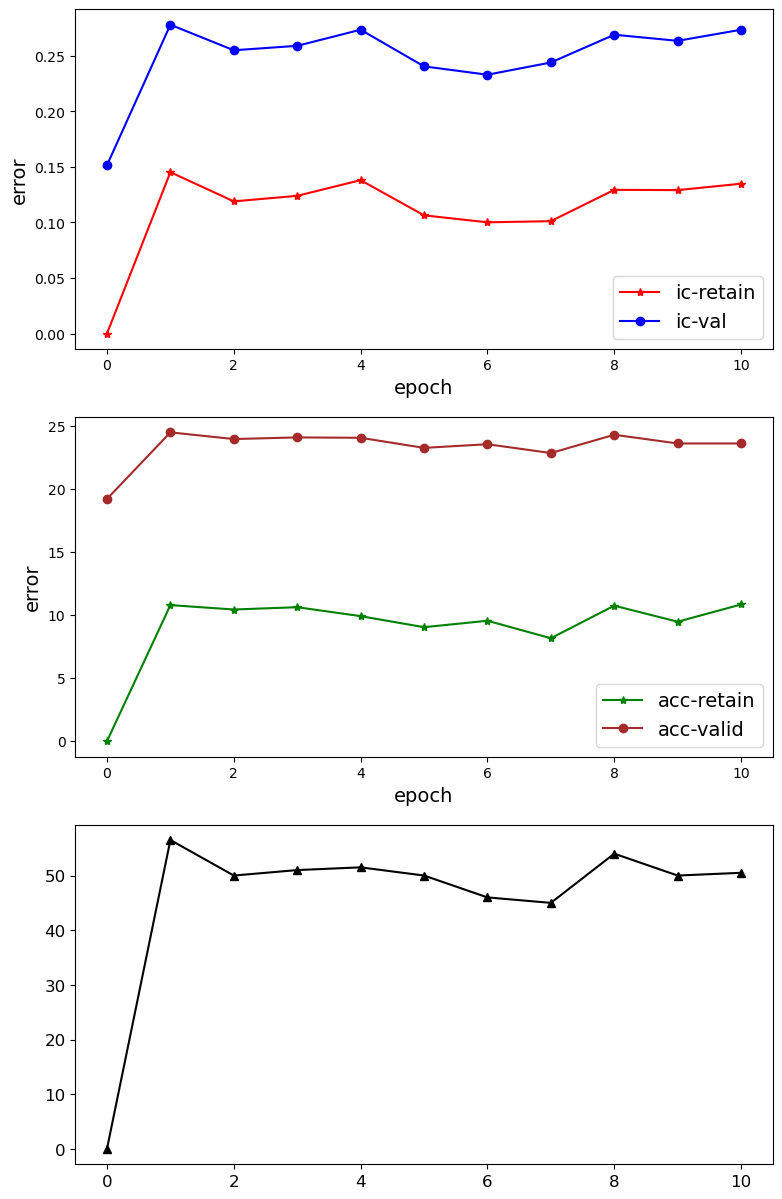

In [25]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(3,1,figsize=(9,15))
indices = list(range(0,len(ic_rs)))
ax[0].plot(indices, ic_rs, marker='*', color='red', alpha=1, label='ic-retain')
ax[0].plot(indices, ic_vs, marker='o', color='blue', alpha=1, label='ic-val')
ax[1].plot(indices, acc_rs, marker='*', color='green', alpha=1, label='acc-retain')
ax[1].plot(indices, acc_vs, marker='o', color='brown', alpha=1, label='acc-valid')
ax[2].plot(indices, acc_fs, marker='^', color='black', alpha=1, label='acc-forget')
ax[0].legend(prop={'size': 14})
ax[1].legend(prop={'size': 14})
plt.tick_params(labelsize=12)
ax[0].set_xlabel('epoch',size=14)
ax[0].set_ylabel('error',size=14)
ax[1].set_xlabel('epoch',size=14)
ax[1].set_ylabel('error',size=14)
fig.show()

## Finetune

In [ ]:
model_ft = copy.deepcopy(model)
args.ft_bs = 64
retain_loader = replace_loader_dataset(train_loader_full,retain_dataset, seed=seed, batch_size=args.ft_bs, shuffle=True)  
finetune(model_ft, retain_loader, epochs=10, quiet=True, lr=0.01)

## Negative Gradient

In [ ]:
args.ng_alpha = 0.9999
args.ng_epochs = 10
args.ng_lr = 0.01
model_ng = copy.deepcopy(model)
args.ng_bs = 128
retain_loader = replace_loader_dataset(train_loader_full,retain_dataset, seed=seed, batch_size=args.ng_bs, shuffle=True)
negative_grad(model_ng, retain_loader, forget_loader, alpha=args.ng_alpha, epochs=args.ng_epochs, quiet=True, lr=args.ng_lr, args=args)

## Catastrophic Forgetting k layers

In [ ]:
args.lr_decay_epochs = [10,15,20]
args.cfk_lr = 0.01
args.cfk_epochs = 10
args.cfk_bs = 128
retain_loader = replace_loader_dataset(train_loader_full,retain_dataset, seed=seed, batch_size=args.cfk_bs, shuffle=True)

model_cfk = copy.deepcopy(model)

for param in model_cfk.parameters():
    param.requires_grad_(False)

if args.model == 'allcnn':
    layers = [9]
    for k in layers:
        for param in model_cfk.features[k].parameters():
            param.requires_grad_(True)
    
elif args.model == "resnet":
    for param in model_cfk.layer4.parameters():
        param.requires_grad_(True)

else:
    raise NotImplementedError



fk_fientune(model_cfk, retain_loader, args=args, epochs=args.cfk_epochs, quiet=True, lr=args.cfk_lr)
cfk_time = t2-t1

## Exact Unlearning k layers

In [ ]:
args.lr_decay_epochs = [10,15,20]
args.euk_lr = 0.01
args.euk_epochs = training_epochs
args.euk_bs = 64
retain_loader = replace_loader_dataset(train_loader_full,retain_dataset, seed=seed, batch_size=args.euk_bs, shuffle=True)
model_euk = copy.deepcopy(model)

for param in model_euk.parameters():
    param.requires_grad_(False)

if args.model == 'allcnn':
    with torch.no_grad():
        for k in layers:
            for i in range(0,3):
                try:
                    model_euk.features[k][i].weight.copy_(model_initial.features[k][i].weight)
                except:
                    print ("block {}, layer {} does not have weights".format(k,i))
                try:
                    model_euk.features[k][i].bias.copy_(model_initial.features[k][i].bias)
                except:
                    print ("block {}, layer {} does not have bias".format(k,i))
        model_euk.classifier[0].weight.copy_(model_initial.classifier[0].weight)
        model_euk.classifier[0].bias.copy_(model_initial.classifier[0].bias)
    
    for k in layers:
        for param in model_euk.features[k].parameters():
            param.requires_grad_(True)
    
elif args.model == "resnet":
    with torch.no_grad():
        for i in range(0,2):
            try:
                model_euk.layer4[i].bn1.weight.copy_(model_initial.layer4[i].bn1.weight)
            except:
                print ("block 4, layer {} does not have weight".format(i))
            try:
                model_euk.layer4[i].bn1.bias.copy_(model_initial.layer4[i].bn1.bias)
            except:
                print ("block 4, layer {} does not have bias".format(i))
            try:
                model_euk.layer4[i].conv1.weight.copy_(model_initial.layer4[i].conv1.weight)
            except:
                print ("block 4, layer {} does not have weight".format(i))
            try:
                model_euk.layer4[i].conv1.bias.copy_(model_initial.layer4[i].conv1.bias)
            except:
                print ("block 4, layer {} does not have bias".format(i))

            try:
                model_euk.layer4[i].bn2.weight.copy_(model_initial.layer4[i].bn2.weight)
            except:
                print ("block 4, layer {} does not have weight".format(i))
            try:
                model_euk.layer4[i].bn2.bias.copy_(model_initial.layer4[i].bn2.bias)
            except:
                print ("block 4, layer {} does not have bias".format(i))
            try:
                model_euk.layer4[i].conv2.weight.copy_(model_initial.layer4[i].conv2.weight)
            except:
                print ("block 4, layer {} does not have weight".format(i))
            try:
                model_euk.layer4[i].conv2.bias.copy_(model_initial.layer4[i].conv2.bias)
            except:
                print ("block 4, layer {} does not have bias".format(i))

        model_euk.layer4[0].shortcut[0].weight.copy_(model_initial.layer4[0].shortcut[0].weight)
        
    for param in model_euk.layer4.parameters():
        param.requires_grad_(True)

else:
    raise NotImplementedError

fk_fientune(model_euk, retain_loader, epochs=args.euk_epochs, quiet=True, lr=args.euk_lr, args=args)
euk_time = t2-t1

## Readouts

In [ ]:
train_loader_full, valid_loader_full, test_loader_full = datasets.get_loaders(dataset, split="train",confuse_mode=True,class_to_replace=class_to_forget, num_indexes_to_replace=num_to_forget, batch_size=args.batch_size, seed=seed, root=args.dataroot, augment=False, shuffle=True)
marked_loader, _, _ = datasets.get_loaders(dataset, split="forget", confuse_mode=True,class_to_replace=class_to_forget, num_indexes_to_replace=num_to_forget, only_mark=True, batch_size=1, seed=seed, root=args.dataroot, augment=False, shuffle=True)

def replace_loader_dataset(data_loader, dataset, batch_size=args.batch_size, seed=1, shuffle=True):
    manual_seed(seed)
    loader_args = {'num_workers': 0, 'pin_memory': False}
    def _init_fn(worker_id):
        np.random.seed(int(seed))
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size,num_workers=0,pin_memory=True,shuffle=shuffle)
    
forget_dataset = copy.deepcopy(marked_loader.dataset)
marked = forget_dataset.targets < 0
forget_dataset.data = forget_dataset.data[marked]
forget_dataset.targets = - forget_dataset.targets[marked] - 1
forget_loader = replace_loader_dataset(train_loader_full, forget_dataset, batch_size=args.forget_bs, seed=seed, shuffle=True)

retain_dataset = copy.deepcopy(marked_loader.dataset)
marked = retain_dataset.targets >= 0
retain_dataset.data = retain_dataset.data[marked]
retain_dataset.targets = retain_dataset.targets[marked]
retain_loader = replace_loader_dataset(train_loader_full, retain_dataset, batch_size=args.retain_bs, seed=seed, shuffle=True)

assert(len(forget_dataset) + len(retain_dataset) == len(train_loader_full.dataset))

In [ ]:
try: readouts
except: readouts = {}

#_,_=activations_predictions(copy.deepcopy(model),forget_loader,'Original_Model_D_f')
#thresh=log_dict['Original_Model_D_f_loss']+1e-5
#print(thresh)
readouts["a"] = all_readouts(test_loader_full, retain_loader, forget_loader, copy.deepcopy(model),thresh=None,name='Original')
readouts["b"] = all_readouts(test_loader_full, retain_loader, forget_loader, copy.deepcopy(model0),thresh=None,name='Retrain')
readouts["c"] = all_readouts(test_loader_full, retain_loader, forget_loader, copy.deepcopy(model_ft),thresh=None,name='Finetune')
readouts["d"] = all_readouts(test_loader_full, retain_loader, forget_loader, copy.deepcopy(model_ng),thresh=None,name='NegGrad')
readouts["e"] = all_readouts(test_loader_full, retain_loader, forget_loader, copy.deepcopy(model_cfk),thresh=None,name='CF-k')
readouts["f"] = all_readouts(test_loader_full, retain_loader, forget_loader, copy.deepcopy(model_euk),thresh=None,name='EU-k')
readouts["h"] = all_readouts(test_loader_full, retain_loader, forget_loader, copy.deepcopy(model_s),thresh=None,name='SCRUB')